# Multivariable regression

## Imports and setup

In [1]:
import pandas as pd

from opengrid.library import houseprint
from opengrid import config
from opengrid.library import regression

c = config.Config()

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

## Load Data

We are going to use gas consumption data and weather data. Because we don't want to overload the weather API, we will only use 1 location (Ukkel).

First, let's define the start and end date of the identification data.  That is the data to be used to find the model.  Later, we will use the model to predict.

In [2]:
start = pd.Timestamp('2015-01-01', tz='Europe/Brussels')
end = pd.Timestamp('2016-01-01', tz='Europe/Brussels')

## Gas Data

In [3]:
# Load the Houseprint, and sync all data
#hp = houseprint.Houseprint()
#hp.save('cache_hp.hp')
hp = houseprint.load_houseprint_from_file('cache_hp.hp')
hp.init_tmpo()

Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [4]:
#hp.sync_tmpos()

In [5]:
#hp.save('cache_hp.hp')

In [6]:
def gas_data_generator():
    # Preferred method: as accurate as 3, and faster
    # Daily approach, obtain fully correct daily data.
    # To be aggregated to monthly or weekly or ...
    
    for gas_sensor in hp.get_sensors(sensortype='gas'):
        df = gas_sensor.get_data(head=start-pd.Timedelta(days=1), 
                                 tail=end+pd.Timedelta(days=1), 
                                 resample='day', 
                                 unit='kWh', 
                                 diff=False, 
                                 tz='Europe/Brussels')
        df = df.diff().shift(-1).dropna()
        if df.empty:
            continue
        yield df

def elec_data_generator():
    # Preferred method: as accurate as 3, and faster
    # Daily approach, obtain fully correct daily data.
    # To be aggregated to monthly or weekly or ...
    
    for sensor in hp.get_sensors(sensortype='electricity'):
        df = sensor.get_data(head=start-pd.Timedelta(days=1), 
                             tail=end+pd.Timedelta(days=1), 
                             resample='day', 
                             unit='kWh', 
                             diff=False, 
                             tz='Europe/Brussels')
        df = df.diff().shift(-1).dropna()
        if df.empty:
            continue
        yield df

Let's have a peek

In [7]:
gas_data = gas_data_generator()
elec_data = elec_data_generator()

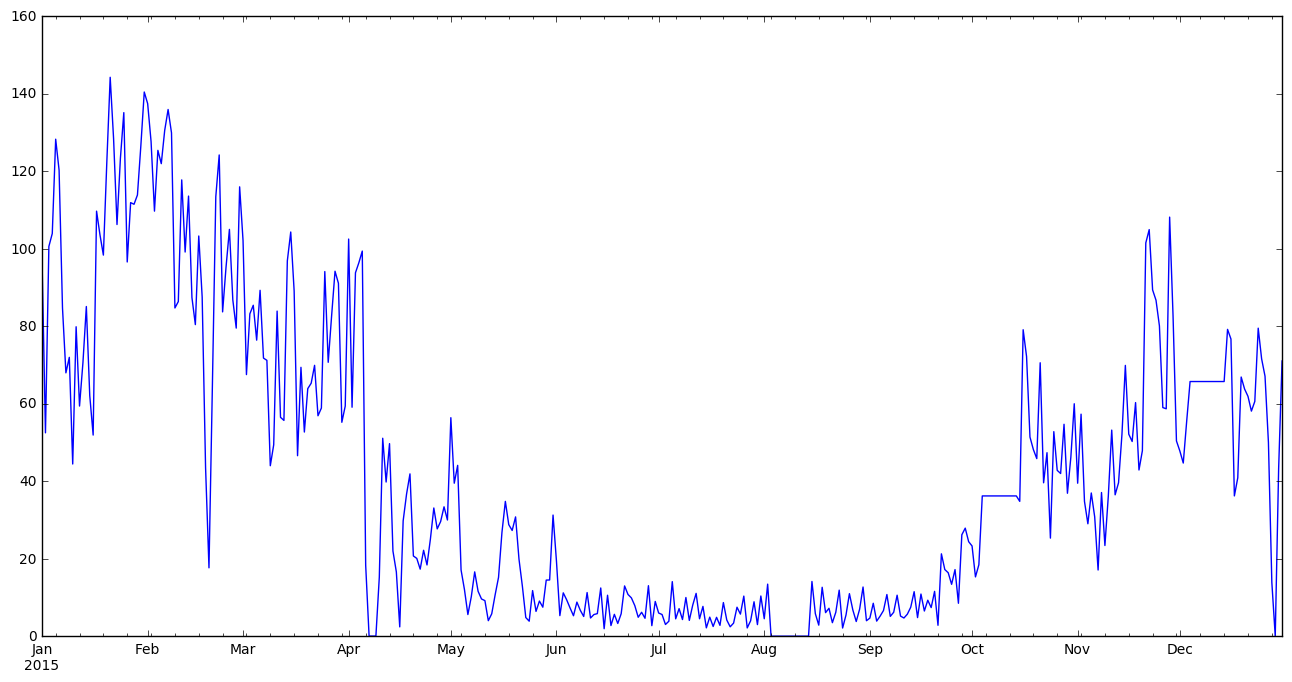

In [8]:
peek = next(gas_data)
peek.plot()

## Weather Data

Run this block to download the weather data and save it to a pickle. This is a large request, and you can only do 2 or 3 of these per day before your credit with Forecast.io runs out!

To get the data run the cell below

In [9]:
from opengrid.library import forecastwrapper
weather = forecastwrapper.Weather(location=(50.8024, 4.3407), start=start, end=end - pd.Timedelta(days=1))
irradiances=[
    (0, 90), # north vertical
    (90, 90), # east vertical
    (180, 90), # south vertical
    (270, 90), # west vertical
]
orientations = [0, 90, 180, 270]
weather_data = weather.days(irradiances=irradiances, 
                            wind_orients=orientations, 
                            heating_base_temperatures=[0, 6, 8 ,10, 12, 14, 16, 18]).dropna(axis=1)
weather_data.drop(['icon', 'summary', 'moonPhase', 'windBearing', 'temperatureMaxTime', 'temperatureMinTime',
                   'apparentTemperatureMaxTime', 'apparentTemperatureMinTime', 'uvIndexTime', 
                   'sunsetTime', 'sunriseTime', 'precipType'], 
                  axis=1, inplace=True)
weather_data = weather_data.applymap(float)

100%|██████████| 365/365 [00:00<00:00, 2927.11it/s]


In [10]:
weather_data.head()

,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,pressure,temperatureMax,temperatureMin,uvIndex,visibility,...,temperatureEquivalent,heatingDegreeDays0,heatingDegreeDays6,heatingDegreeDays8,heatingDegreeDays10,heatingDegreeDays12,heatingDegreeDays14,heatingDegreeDays16,heatingDegreeDays18,coolingDegreeDays18
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,0.76,-4.76,0.24,-0.82,0.82,1034.24,4.86,-0.62,1.0,9.11,...,2.191542,0.0,3.808458,5.808458,7.808458,9.808458,11.808458,13.808458,15.808458,0.0
2015-01-02 00:00:00+01:00,5.84,-2.42,0.56,2.12,0.80,1029.26,8.78,2.71,1.0,10.27,...,4.130042,0.0,1.869958,3.869958,5.869958,7.869958,9.869958,11.869958,13.869958,0.0
2015-01-03 00:00:00+01:00,-0.48,-2.78,0.73,1.07,0.90,1025.44,3.77,1.20,0.0,7.76,...,3.376708,0.0,2.623292,4.623292,6.623292,8.623292,10.623292,12.623292,14.623292,0.0
2015-01-04 00:00:00+01:00,2.44,-2.87,0.30,1.14,0.95,1034.44,4.10,0.35,1.0,6.34,...,2.409958,0.0,3.590042,5.590042,7.590042,9.590042,11.590042,13.590042,15.590042,0.0
2015-01-05 00:00:00+01:00,2.87,-5.01,0.34,-0.46,0.90,1033.06,4.67,-0.94,0.0,7.81,...,1.420583,0.0,4.579417,6.579417,8.579417,10.579417,12.579417,14.579417,16.579417,0.0


In [11]:
weather_data.columns

Index(['apparentTemperatureMax', 'apparentTemperatureMin', 'cloudCover',
       'dewPoint', 'humidity', 'pressure', 'temperatureMax', 'temperatureMin',
       'uvIndex', 'visibility', 'windSpeed', 'temperature',
       'GlobalHorizontalIrradiance', 'GlobalIrradianceO0T90',
       'GlobalIrradianceO90T90', 'GlobalIrradianceO180T90',
       'GlobalIrradianceO270T90', 'windComponent0', 'windComponentSquared0',
       'windComponentCubed0', 'windComponent90', 'windComponentSquared90',
       'windComponentCubed90', 'windComponent180', 'windComponentSquared180',
       'windComponentCubed180', 'windComponent270', 'windComponentSquared270',
       'windComponentCubed270', 'temperatureEquivalent', 'heatingDegreeDays0',
       'heatingDegreeDays6', 'heatingDegreeDays8', 'heatingDegreeDays10',
       'heatingDegreeDays12', 'heatingDegreeDays14', 'heatingDegreeDays16',
       'heatingDegreeDays18', 'coolingDegreeDays18'],
      dtype='object')

# Put data together

I wrote a generator that uses our previously defined generator so you can generate while you generate.

In [12]:
def analysis_data_generator():
    gas_data = gas_data_generator()
    for gas_df in gas_data:
        gas_df.name='gas'
        df = pd.concat([gas_df, weather_data], axis=1).dropna()
        df = df.tz_convert('Europe/Brussels')
        yield df

Let's have another peek

In [13]:
analysis_data = analysis_data_generator()

# Run Regression Analysis


We run the analysis on monthly and weekly basis.

/usr/local/opengrid/opengrid/library/regression.py:312: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  dfmodel.sort(inplace=True)
/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace)


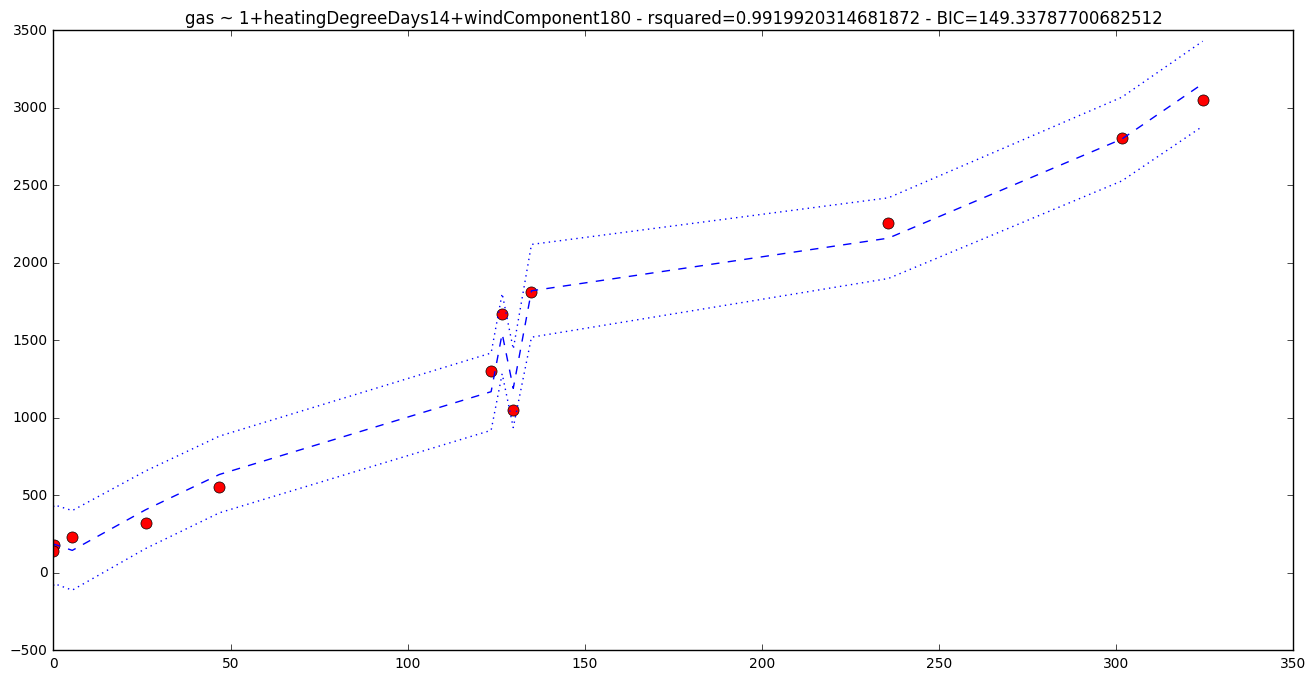

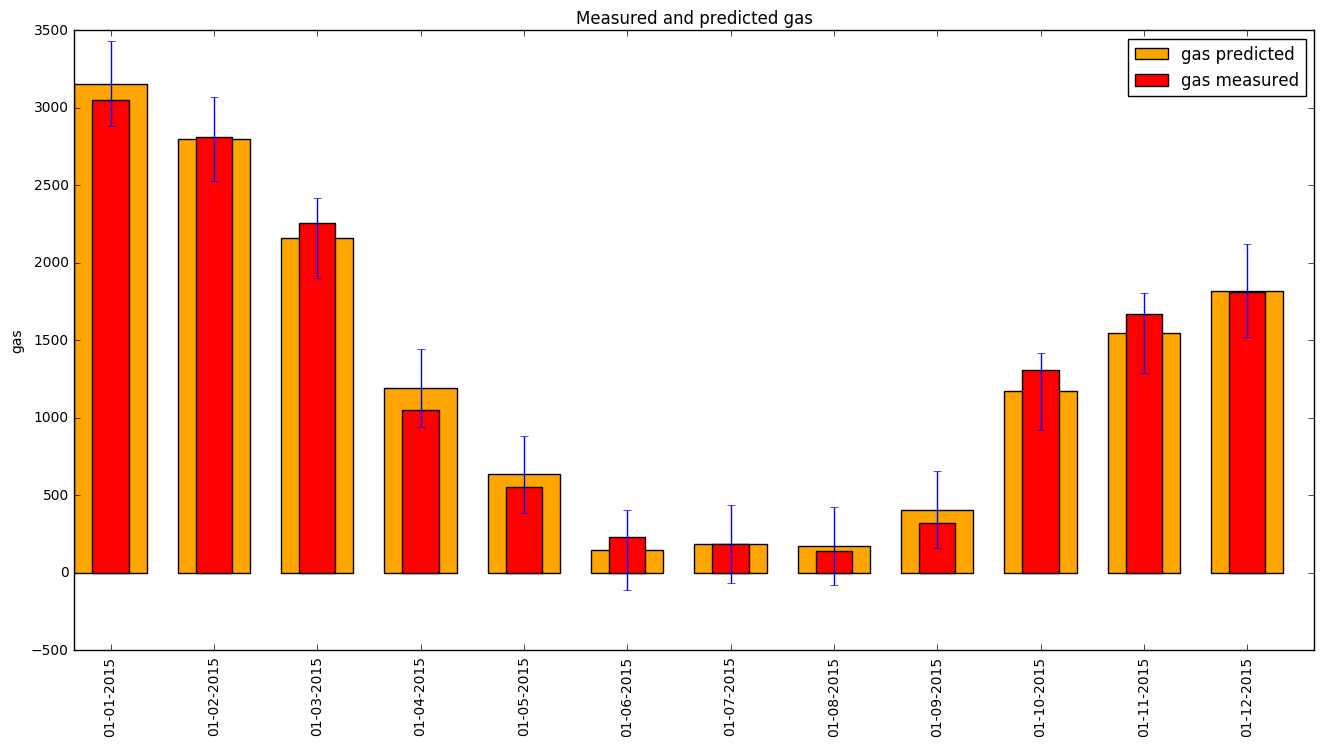

In [ ]:
analysis_data = analysis_data_generator()
mrs_month = []
mrs_month_cv = []
mrs_week = []
for data in analysis_data: 
    
    df = data.resample(rule='MS').sum()
    if len(df) < 2:
        continue
    
    # monthly model, statistical validation
    mrs_month.append(regression.MVLinReg(df, 'gas', p_max=0.05)) 
    mrs_month[-1].plot()
    
    # monthly model, cross-validation
    mrs_month_cv.append(regression.MVLinReg(df, 'gas', p_max=0.05, cross_validation=True)) 
    mrs_month_cv[-1].plot()
    
    # weekly model, statistical validation
    df = data.resample(rule='W').sum()
    mrs_week.append(regression.MVLinReg(df, 'gas', p_max=0.05)) 
    mrs_week[-1].plot()
    
    

In [16]:
import pdb;pdb.pm()

> /usr/local/lib/python3.5/dist-packages/statsmodels/base/data.py(93)_handle_constant()
-> const_idx = np.where(self.exog.ptp(axis=0) == 0)[0].squeeze()
(Pdb) u
> /usr/local/lib/python3.5/dist-packages/statsmodels/base/data.py(75)__init__()
-> self._handle_constant(hasconst)
(Pdb) u
> /usr/local/lib/python3.5/dist-packages/statsmodels/base/data.py(566)handle_data()
-> **kwargs)
(Pdb) u
> /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py(84)_handle_data()
-> data = handle_data(endog, exog, missing, hasconst, **kwargs)
(Pdb) u
> /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py(60)__init__()
-> **kwargs)
(Pdb) u
> /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py(186)__init__()
-> super(LikelihoodModel, self).__init__(endog, exog, **kwargs)
(Pdb) u
> /usr/local/lib/python3.5/dist-packages/statsmodels/regression/linear_model.py(91)__init__()
-> super(RegressionModel, self).__init__(endog, exog, **kwargs)
(Pdb) u
> /usr/local/lib/python3.5/dist-

In [ ]:
for i, fit in enumerate(mrs_month[3].list_of_fits):
    print('{}: {}'.format(fit.model.formula, mrs_month[3].list_of_cverrors[i]))

In [ ]:
print(mrs_month[3].list_of_fits[-1].summary())